🧠 Iniciando Módulo de Explicabilidad (XAI)...

🔬 Simulando paciente con INFECCIÓN...
🤖 Diagnóstico IA: Infection
📈 Confianza: 99.95%
🔧 Debug: Detectado formato ARRAY (1, 11, 4)
📸 Guardado: shap_patient_explanation.png (Waterfall Plot)

✅ Módulo de Explicabilidad validado.


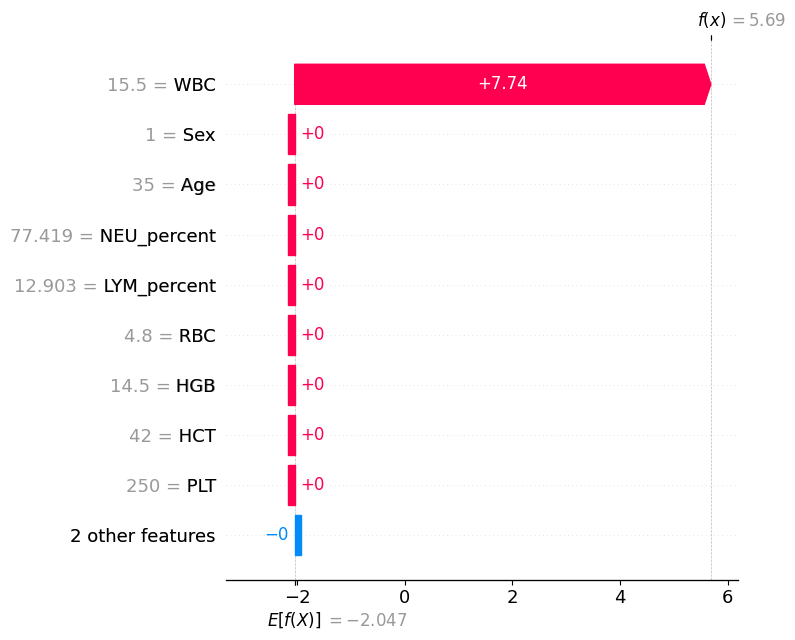

In [3]:
import pandas as pd
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import joblib
import numpy as np

def explain_model():
    print("🧠 Iniciando Módulo de Explicabilidad (XAI)...")

    # 1. Cargar Datos y Modelo
    df = pd.read_csv("nhanes_labeled_data.csv")
    X = df.drop(columns=['Diagnosis', 'ID'])
    
    model = xgb.XGBClassifier()
    model.load_model("xgboost_clinical_v1.json")
    
    try:
        le = joblib.load('label_encoder.joblib')
        class_names = le.classes_
    except:
        class_names = [0, 1, 2, 3]

    # 2. Inicializar SHAP
    explainer = shap.TreeExplainer(model)
    
    # 3. Simulación de Paciente "Infección"
    print("\n🔬 Simulando paciente con INFECCIÓN...")
    
    # Valores base
    patient_data = pd.DataFrame({
        'Sex': [1], 'Age': [35],
        'WBC': [15.5], 'NEU': [12.0], 'LYM': [2.0],
        'RBC': [4.8], 'HGB': [14.5], 'HCT': [42.0],
        'MCV': [88.0], 'MCH': [30.0], 'PLT': [250.0]
    })

    # Calcular columnas derivadas (Feature Engineering)
    patient_data['NEU_percent'] = (patient_data['NEU'] / patient_data['WBC']) * 100
    patient_data['LYM_percent'] = (patient_data['LYM'] / patient_data['WBC']) * 100
    
    # Reordenar columnas
    patient_data = patient_data[X.columns]
    
    # Predecir Clase
    pred_idx = model.predict(patient_data)[0]
    pred_prob = model.predict_proba(patient_data)[0]
    predicted_class = class_names[pred_idx]
    
    print(f"🤖 Diagnóstico IA: {predicted_class}")
    print(f"📈 Confianza: {pred_prob[pred_idx]*100:.2f}%")

    # 4. Explicación Local (Waterfall) - FIX ROBUSTO
    # Obtenemos los valores shap para este paciente
    shap_vals_instance = explainer.shap_values(patient_data)
    
    # --- BLOQUE DE DETECCIÓN DE FORMATO ---
    if isinstance(shap_vals_instance, list):
        # Formato Antiguo: Lista de matrices [Clase0, Clase1...]
        print("🔧 Debug: Detectado formato LISTA")
        shap_values_target = shap_vals_instance[pred_idx][0]
        expected_val = explainer.expected_value[pred_idx]
    else:
        # Formato Nuevo: Array 3D (samples, features, classes)
        print(f"🔧 Debug: Detectado formato ARRAY {shap_vals_instance.shape}")
        # Queremos: Paciente 0, Todas las features (:), Clase predicha (pred_idx)
        shap_values_target = shap_vals_instance[0, :, pred_idx]
        
        # El expected_value también puede cambiar de formato
        if isinstance(explainer.expected_value, list) or isinstance(explainer.expected_value, np.ndarray):
             expected_val = explainer.expected_value[pred_idx]
        else:
             expected_val = explainer.expected_value
    # --------------------------------------

    plt.figure()
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values_target,
            base_values=expected_val,
            data=patient_data.iloc[0],
            feature_names=patient_data.columns
        ),
        show=False
    )
    # Ajuste de márgenes para que no se corten las etiquetas
    plt.tight_layout()
    plt.savefig("shap_patient_explanation.png", bbox_inches='tight')
    print("📸 Guardado: shap_patient_explanation.png (Waterfall Plot)")
    
    print("\n✅ Módulo de Explicabilidad validado.")

if __name__ == "__main__":
    explain_model()